# CRM CW2 Pre-Processing Code

## Data Information

In [34]:
import pandas as pd
import numpy as np
import re
#sklearn version 1.0.1
from sklearn.impute import SimpleImputer
from scipy.stats import iqr
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from woe import feature_process as fp
import woe.eval as weval

In [2]:
#Old data:FameData2015-2019.csv
Cdata = pd.read_csv('FameData2015-2019.csv')
Cdata.replace('',np.nan, inplace=True)
Cdata.describe()

,Primary UK SIC (2007) code,Credit score,Likelihood of failure (%)\n%,Previous credit score,Return on Shareholders Funds (%),Return on Capital Employed (%),Return on Total Assets (%),Profit margin (%),Gross margin (%),EBIT margin (%),...,Cash In(Out)flow Ret. On Invest.\nm EUR,Taxation\nm EUR,Cash Out(In)flow Investing Activ.\nm EUR,Capital Expenditure & Financ. Invest.\nm EUR,Acquisition & Disposal\nm EUR,Equity Dividends Paid\nm EUR,Management of Liquid Resources\nm EUR,Cash Out(In)flow from Financing\nm EUR,Increase (Decrease) Cash & Equiv.\nm EUR,Asset Cover (x)
count,5415.000000,4985.000000,4985.000000,4985.000000,4513.000000,4954.000000,4948.000000,4651.000000,3714.000000,4919.000000,...,2491.000000,1804.000000,433.000000,2960.000000,692.000000,1634.000000,3.000000,2395.000000,2989.000000,2127.000000
mean,62962.096953,86.624875,1.734905,83.474423,30.573621,23.953652,12.092454,12.151722,30.009435,10.987567,...,-0.177439,-0.519956,-3.812933,-1.652703,0.546243,9.622179,-4.333333,0.694781,0.831047,40.703977
std,12726.255012,18.714284,2.508490,21.219128,83.170346,74.512778,41.912197,23.278793,28.467643,20.283835,...,1.501481,1.252902,22.158198,6.023862,3.178601,54.930060,4.932883,28.233866,11.939743,110.959528
min,1110.000000,0.000000,0.900000,23.000000,-905.040000,-817.840000,-725.000000,-99.390000,-67.430000,-96.590000,...,-35.000000,-25.000000,-419.000000,-112.000000,-31.000000,-87.000000,-10.000000,-81.000000,-399.000000,0.380000
25%,64205.000000,88.000000,0.900000,85.000000,2.000000,3.502500,1.470000,1.610000,8.710000,1.925000,...,0.000000,-1.000000,-3.000000,-2.000000,0.000000,-1.000000,-6.000000,-1.000000,-1.000000,2.845000
50%,66190.000000,93.000000,0.900000,92.000000,16.110000,15.305000,7.450000,6.480000,22.270000,6.350000,...,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-2.000000,0.000000,0.000000,7.340000
75%,70100.000000,97.000000,0.900000,97.000000,42.080000,35.710000,17.380000,18.485000,42.397500,16.020000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.755000,-1.500000,1.000000,2.000000,22.405000
max,96090.000000,99.000000,14.500000,99.000000,995.620000,985.780000,876.630000,100.000000,329.000000,99.960000,...,20.000000,5.000000,38.000000,43.000000,30.000000,872.060000,-1.000000,905.000000,462.000000,964.040000


In [3]:
C_columns = list(Cdata.columns)
print(C_columns)

['Company name', 'Inactive', 'Quoted', 'Branch', 'OwnData', 'Woco', 'R/O Full Postcode', 'Registered number', 'Primary UK SIC (2007) code', 'Latest accounts date', 'Company status', 'Credit score', 'Credit score date', 'Credit score indicator', 'Likelihood of failure (%)\n%', 'Credit limit (GBP)\nGBP', 'Previous credit score', 'Previous credit score date', 'Previous credit score indicator', 'Ultimate owner', 'Total Assets\nm EUR', 'Return on Shareholders Funds (%)', 'Operating revenue (Turnover)\nm EUR', 'Return on Capital Employed (%)', 'Return on Total Assets (%)', 'Profit margin (%)', 'Gross margin (%)', 'Berry ratio', 'EBIT margin (%)', 'EBITDA margin (%)', 'Net Assets Turnover (x)', 'Fixed Assets Turnover (x)', 'Interest Cover (x)', 'Stock Turnover (x)', 'Debtors Turnover (x)', 'Debtor Collection (days)', 'Creditors Payment (days)', 'Current ratio (x)', 'Liquidity ratio (x)', 'Shareholders liquidity ratio (x)', 'Solvency ratio (Asset based) (%)', 'Solvency ratio (Liability based) 

In [4]:
Cdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5415 entries, 0 to 5414
Data columns (total 58 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Company name                                 5415 non-null   object 
 1   Inactive                                     5415 non-null   object 
 2   Quoted                                       5415 non-null   object 
 3   Branch                                       5415 non-null   object 
 4   OwnData                                      5415 non-null   object 
 5   Woco                                         5415 non-null   object 
 6   R/O Full Postcode                            5415 non-null   object 
 7   Registered number                            5415 non-null   object 
 8   Primary UK SIC (2007) code                   5415 non-null   int64  
 9   Latest accounts date                         5415 non-null   object 
 10  

\pagebreak

### Pre-process for predictors

•	Missing values: imputed with the mean value or mode value for numerical variables and nominal variables

•	Remove the variables with missing proportions over 60%

•	Outlier detection: interquartile range (IQR) method

In [5]:
#3.1 missing values and 3.2 remove nan ratio>.6
imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
for items in Cdata.columns:
    NaN_ratio = len(Cdata[pd.isnull(Cdata[items])])/len(Cdata)
    #print(items,'nan ratio is:',NaN_ratio)
    if NaN_ratio >= 0.6:
        C_columns.remove(str(items))
        Cdata.drop(items, axis=1, inplace=True)
        
imp_mostf = imp.fit(Cdata)
#After this step, the type of Cdata changed from pd.Datafram to np.ndarray
Cdata = imp_mostf.transform(Cdata)

#3.3 outlier detection: iqr could only calculate numbers
#for i in range (4,len(Cdata[1])):
    #print('Outlier in', C_columns[i],'is:', iqr(Cdata[:,i], rng=(25,75), interpolation='midpoint'))
print(Cdata[1])

['GRWP WRW CYF' 'No' 'No' 'No' 'No' 'No' 'M1 4PB' '3523416' 41201
 '31/12/2019' 'Active, in administration' 99.0 '17/12/2021' 'Secure' 0.9
 '500' 99.0 '31/12/2019' 'Secure' 'GRWP WRW CYF' '17' 20.22 '44' 18.23 3.5
 1.31 6.59 '1' 1.42 2.27 13.94 16.17 11.99 46.69 4.67 78.2 44.83 1.03 0.96
 9.17 '17.31' 20.94 38.17 '6,216' '30,742' 1.0 0.0 -1.0 0.0 1.0 '2016' 'D']


#### Find index number

In [6]:
print("Credit score Index:",C_columns.index('Credit score'))

Credit score Index: 11


## Save the pre-processed data in to a csv

Remember to change the document's name!!

In [57]:
pd_data = pd.DataFrame(Cdata,columns= C_columns)
#print(pd_data[:3])
pd_data.to_csv('After_PP_2015-2019FD.csv')

\pagebreak

# 3-year Fliter + Group

pre_processing.py+Data_grouping.py

In [29]:
def choose_correct_score(credit_score_date, year, credit_score, previous_credit_score):
    if credit_score_date - year == 3:
        return credit_score
    else:
        return previous_credit_score

def create_groups(credit_score):
    if float(credit_score)<40:
        return 1
    elif float(credit_score)>60 :
        return 3
    else:
        return 2

def extract_year_from_date_string(df, column_name):
    df[column_name] = df[column_name].str.split('/', expand=True)[2]
    return df

In [30]:
if __name__ == '__main__':
    after_pp_df = pd.read_csv("After_PP_2015-2019FD.csv")
    after_pp_df = extract_year_from_date_string(after_pp_df, 'Previous credit score date')
    after_pp_df = extract_year_from_date_string(after_pp_df, 'Credit score date')
    after_pp_df['Previous credit score date'] = pd.to_numeric(after_pp_df['Previous credit score date'])
    after_pp_df['Credit score date'] = pd.to_numeric(after_pp_df['Credit score date'])
    after_pp_df['Year'] = after_pp_df['Year'].str.replace(r'\D', '').astype(int)
    after_pp_df['Year'] = pd.to_numeric(after_pp_df['Year'])

    filtered_df = after_pp_df[(after_pp_df['Credit score date'] - after_pp_df['Year'] == 3) | (after_pp_df['Previous credit score date'] - after_pp_df['Year'] == 3)]

    # Checking results are as expected
    test_makes_sense = filtered_df[['Credit score date', 'Previous credit score date', 'Year']]

    # choose the credit score which matches the difference
    filtered_df['Final credit score'] = filtered_df.apply(lambda x: choose_correct_score(x['Credit score date'], x['Year'], x['Credit score'], x['Previous credit score']), axis=1)
    # drop the other two
    filtered_df = filtered_df.drop(['Unnamed: 0','Previous credit score'], axis=1)
    # create the 4 target groups
    filtered_df['Group'] = filtered_df.apply(lambda x: create_groups(x['Credit score']), axis=1)
    value_counts_group = filtered_df['Group'].value_counts()
    filtered_df = filtered_df.drop(['Credit score','D/N'], axis=1)
    filtered_df.to_csv("Updated_final_df.csv")

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


\pagebreak

# Feature selection

Initial Features count: 31


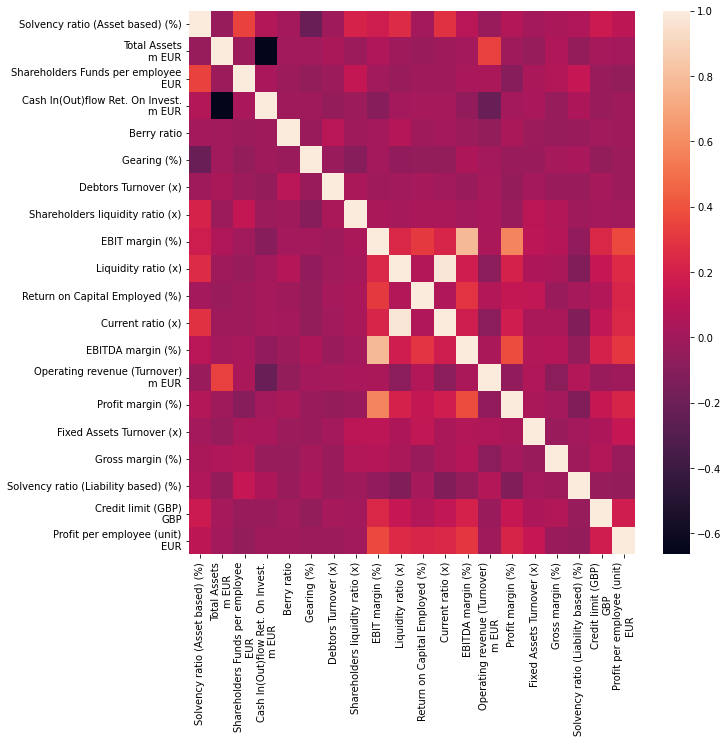

Final features list: Index(['Solvency ratio (Asset based) (%)', 'Total Assets\nm EUR',
       'Shareholders Funds per employee\nEUR',
       'Cash In(Out)flow Ret. On Invest.\nm EUR', 'Berry ratio', 'Gearing (%)',
       'Debtors Turnover (x)', 'Shareholders liquidity ratio (x)',
       'EBIT margin (%)', 'Liquidity ratio (x)',
       'Return on Capital Employed (%)', 'EBITDA margin (%)',
       'Operating revenue (Turnover)\nm EUR', 'Profit margin (%)',
       'Fixed Assets Turnover (x)', 'Gross margin (%)',
       'Solvency ratio (Liability based) (%)', 'Credit limit (GBP)\nGBP',
       'Profit per employee (unit)\nEUR'],
      dtype='object')
Final features count: 19


In [33]:
def remove_irrelevant_features(df):
    # remove features that are irrelevant for credit risk scoring e.g. legal information, addresses, etc..
    # Removed likelihood of failure since it's determined by the credit risk score, which is our target variable
    df.drop(["Company name", "Inactive", "Quoted", "Branch", "OwnData", "Woco", 'R/O Full Postcode', 'Registered number',
             'Primary UK SIC (2007) code', 'Latest accounts date', 'Latest accounts date', 'Company status',
             'Credit score date', 'Credit score indicator', 'Previous credit score date',
             'Previous credit score indicator',
             'Ultimate owner', 'Year', 'Likelihood of failure (%)\n%'], axis=1, inplace=True)
    return df

def turn_to_float(i):
    if isinstance(i, str):
        i = re.sub(r'[^\w\s]', '', i)
        i = float(i)
    else:
        i = float(i)
    return i

def ANOVA_F(X, y, n):
    # Get the F statistic and p values
    F_statistic, p_values = f_classif(X, y)

    # convert to a DF
    ANOVA_F_df= pd.DataFrame(data={'Feature_list': X.columns.values,
                                       'F-Score': F_statistic, 'p values': p_values.round(decimals=8)})
    ANOVA_F_df.sort_values(by=['F-Score'], ascending=False, ignore_index=True, inplace=True)

    # returns the updated data with the top n features
    top_n_features = ANOVA_F_df.iloc[:n, 0].to_list()
    new_data = X[top_n_features]

    return new_data, top_n_features

def corr_matrix(df, thresh):

    # calculate pair-wise correlations between them
    corr = df.corr()
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr)
    plt.show()

    corr_select = np.full((corr.shape[0],), True, dtype=bool)
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= thresh:
                if corr_select[j]:
                    corr_select[j] = False

    return corr_select

if __name__ == "__main__":
    # load csv
    crm_df = pd.read_csv('Updated_final_df.csv')

    # remove repeated index columns
    crm_df.drop(crm_df.filter(regex="Unname"), axis=1, inplace=True)

    # remove irrelevant features
    stripped_df = remove_irrelevant_features(crm_df)


    # drop credit score column since we're classifying based on the groups
    stripped_df.drop(['Final credit score'], axis=1, inplace=True)

    # Split the data into a 75/25 split while maintaining the same distribution of classes in the both splits
    X = stripped_df.drop(['Credit Group'], axis=1)
    y = stripped_df['Credit Group']

    for c in X.columns:
        X[c] = X.apply(lambda x: turn_to_float(x[c]), axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        random_state=99, stratify=y)

    # check initial features count
    print("Initial Features count: {}".format(len(X_train.columns)))

    # set feature selection parameters
    n = 20
    thresh = 0.9

    # Get the top n features from the ANOVA_F test
    new_data, top_features = ANOVA_F(X_train, y_train, n)

    # Build the correlation matrix and remove features higher than thresh
    selected_columns = new_data.columns[corr_matrix(new_data, thresh)]
    final_data = new_data[selected_columns]
    print('Final features list: {}'.format(final_data.columns))
    print('Final features count: {}'.format(len(final_data.columns)))

\pagebreak

### WOE METHOD

In [36]:
def WoE_official_eg(data):
    #for saving woe data
    data_woe = data 
    civ_list = []
    n_positive = sum(data['target'])
    n_negtive = len(data) - n_positive
    for column in list(data.columns[:-1]):
        if data[column].dtypes == 'object':
            civ = fp.proc_woe_discrete(data, column, n_positive, n_negtive, 0.05*len(data), alpha=0.05)
        else:            
            civ = fp.proc_woe_continuous(data, column, n_positive, n_negtive, 0.05*len(data), alpha=0.05)
        civ_list.append(civ)
        data_woe[column] = fp.woe_trans(data[column], civ)
    
    civ_df = weval.eval_feature_detail(civ_list,'WoE_feature_detail.csv')
    #delete little iv value
    iv_thre = 0.1
    iv = civ_df[['var_name','iv']].drop_duplicates()
    x_columns = iv.var_name[iv.iv > iv_thre]
    
    return x_columns

In [37]:
test_data = X_train[list(final_data.columns)]

test_target = []
for i in list(y_train):
    if int(i) == 3:
        test_target.append(1)
    else:
        test_target.append(0)
test_data['target'] = test_target

x_col = WoE_official_eg(test_data)
print("\nfeature list after WoE:",x_col)
print("features count:",len(x_col))

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


process continuous variable:Solvency ratio (Asset based) (%)


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


-------process continuous variable:Total Assets
m EUR-------
process continuous variable:Shareholders Funds per employee
EUR
process continuous variable:Cash In(Out)flow Ret. On Invest.
m EUR
----------process continuous variable:Berry ratio-----------
----------process continuous variable:Gearing (%)-----------
------process continuous variable:Debtors Turnover (x)------
process continuous variable:Shareholders liquidity ratio (x)
--------process continuous variable:EBIT margin (%)---------
------process continuous variable:Liquidity ratio (x)-------
-process continuous variable:Return on Capital Employed (%)-
-------process continuous variable:EBITDA margin (%)--------
process continuous variable:Operating revenue (Turnover)
m EUR
-------process continuous variable:Profit margin (%)--------
---process continuous variable:Fixed Assets Turnover (x)----
--------process continuous variable:Gross margin (%)--------
process continuous variable:Solvency ratio (Liability based) (%)
-----proc

In [38]:
#Next if you want to use the 15 features:
#X_train[list(x_col)]
#X_test[list(x_col)]

data = pd.read_csv('Updated_final_df.csv')
temp = list(x_col).append('Credit Group')
data = data[list(x_col)]
data.to_csv('CW2_DATA.csv')